In [1]:
from utils.spark_utils import get_spatial_spark_session
from utils.params import CENS_STAGING_PATH
from utils.dbutils import sdf_df_from_query

In [2]:
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter
import json
from pyspark.sql import functions as f

lad:https://geoportal.statistics.gov.uk/maps/local-authority-districts-december-2022-boundaries-uk-bfc
msoa: https://geoportal.statistics.gov.uk/datasets/ons::msoa-dec-2021-boundaries-full-extent-bfe-ew/explore?location=52.800674%2C-2.487028%2C8.00
ward: https://geoportal.statistics.gov.uk/maps/wards-december-2022-boundaries-gb-bfc
op: https://geoportal.statistics.gov.uk/maps/output-areas-dec-2021-boundaries-full-clipped-ew-bfc

In [3]:
spark = get_spatial_spark_session("DBT Muthafucka")

23/02/12 08:36:50 WARN Utils: Your hostname, DESKTOP-9QGN9QQ resolves to a loopback address: 127.0.1.1; using 172.30.151.34 instead (on interface eth0)
23/02/12 08:36:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/02/12 08:36:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# investigate postcode lad

In [5]:
pc_lad = spark.read.parquet("/mnt/c/Users/lohith/Downloads/OS_data_sets/processed/postcode_lad")

In [6]:
pc_lad.count()

2018126

In [7]:
pc_lad

DataFrame[postcode: string, district: string, postcode_orig: string, postcode_point_4326: udt, postcode_point_3857: udt, geo_hash: string, postcode_origin: string, geometry: udt, postcode_poly_4326: udt, lad_cd: string]

## Create lad_oa_geo_w_lad_partition

In [5]:
# Spread the geo across partitions for easier read
oa_spark_geo = spark.read.parquet(f"{CENS_STAGING_PATH}/geo_parquets/oa/")\
    .withColumn("poly_4326", f.expr(
        "ST_FlipCoordinates(poly_4326_fc)"
    )).selectExpr("OA21CD as oa21cd", "poly_4326 as oa_poly_4326")

lad_spark_geo = spark.read.parquet(f"{CENS_STAGING_PATH}/geo_parquets/lad/")\
    .withColumn("poly_4326", f.expr(
        "ST_FlipCoordinates(poly_4326_fc)"
    )).selectExpr("LAD22CD as lad22cd", "poly_4326 as lad_poly_4326")

In [6]:
query = "select distinct OA21CD as oa21cd, LTLA22CD as lad22cd from oa_to_ward_mapping"
oa_to_lad = sdf_df_from_query("crimeapp", query, spark)

In [8]:
oa_spark_geo, lad_spark_geo, oa_to_lad

(DataFrame[oa21cd: string, oa_poly_4326: udt],
 DataFrame[lad22cd: string, lad_poly_4326: udt],
 DataFrame[lad22cd: string, oa21cd: string])

In [9]:
oa_lad_geo_part_lad = oa_spark_geo.join(
    f.broadcast(oa_to_lad),
    "oa21cd",
    "inner"
).join(
    lad_spark_geo,
    "lad22cd",
    "inner"
)

oa_lad_geo_part_lad

DataFrame[lad22cd: string, oa21cd: string, oa_poly_4326: udt, lad_poly_4326: udt]

In [ ]:
oa_lad_geo_part_lad.repartition(4, "oa21cd")\
.write.mode("overwrite")\
.partitionBy("lad22cd")\
.parquet(f"/home/basal/cens_staging/temp/oa_lad_geo_part_lad/")

23/02/11 01:54:06 WARN TaskSetManager: Stage 5 contains a task of very large size (1207 KiB). The maximum recommended task size is 1000 KiB.


## Do pip now

In [11]:
spark

In [11]:
import glob

In [12]:
query = "select distinct lat, lon from crime_point_index where lat is not null and lon is not null order by lat, lon"
crime_point_index = sdf_df_from_query("crimeapp", query, spark)

In [9]:
noP= spark.read.parquet("/home/basal/cens_staging/temp/oa_lad_geo_part_lad/")

In [12]:
noP.filter("oa_poly_4326 is null").count()

0

In [23]:
partitions = glob.glob("/home/basal/cens_staging/temp/oa_lad_geo_part_lad/lad22cd=*")
processed_partitions_path = glob.glob("/home/basal/cens_staging/temp/crime_index_w_oa_part_lad/lad22cd=*")

processed_partitions = [x.split('=')[-1] for x in processed_partitions_path]

to_be_processed = [partition for partition in partitions if  partition.split('=')[-1] not in processed_partitions]
# to_be_processed

In [57]:
for partition in partitions:
    ladcd = partition.split('=')[-1]
    # print(ladcd)

In [24]:
for partition in to_be_processed:
    ladcd = partition.split('=')[-1]
    oa_geo_lad_partition=spark.read.parquet(f"{partition}")\
        .filter("oa_poly_4326 is not null")\
        .drop("lad_poly_4326")
    
    oa_geo_lad_partition_op = oa_geo_lad_partition.alias("geo").join(
        f.broadcast(crime_point_index).alias("crimeIndex"),
        f.expr("""
            ST_Contains(geo.oa_poly_4326, ST_Point(crimeIndex.lat, crimeIndex.lon))
        """),
        how='inner'
    )\
    .withColumn("lad22cd", f.lit(f"{ladcd}"))\
    .selectExpr(
        "oa21cd",
        "lat",
        "lon",
        "lad22cd"
    )
    oa_geo_lad_partition_op\
        .write.mode("overwrite")\
        .partitionBy("lad22cd")\
        .parquet(f"/home/basal/cens_staging/temp/crime_index_w_oa_part_lad/")

23/02/11 13:15:50 WARN TaskSetManager: Stage 12 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:16:20 WARN TaskSetManager: Stage 15 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:18:26 WARN TaskSetManager: Stage 18 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:19:26 WARN TaskSetManager: Stage 21 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:20:14 WARN TaskSetManager: Stage 24 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:21:29 WARN TaskSetManager: Stage 27 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:22:35 WARN TaskSetManager: Stage 30 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:23:20 WARN TaskSetManager: Stage 33 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:24:15 WARN TaskSetManager: Stage 36 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:25:18 WARN TaskSetManager: Stage 39 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:26:11 WARN TaskSetManager: Stage 42 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:27:23 WARN TaskSetManager: Stage 45 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:27:47 WARN TaskSetManager: Stage 48 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:28:21 WARN TaskSetManager: Stage 51 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:29:02 WARN TaskSetManager: Stage 54 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:29:37 WARN TaskSetManager: Stage 57 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:30:10 WARN TaskSetManager: Stage 60 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:30:47 WARN TaskSetManager: Stage 63 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:31:32 WARN TaskSetManager: Stage 66 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:31:58 WARN TaskSetManager: Stage 69 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:32:24 WARN TaskSetManager: Stage 72 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:32:52 WARN TaskSetManager: Stage 75 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:33:27 WARN TaskSetManager: Stage 78 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:33:40 WARN TaskSetManager: Stage 81 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:34:25 WARN TaskSetManager: Stage 84 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:35:30 WARN TaskSetManager: Stage 87 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:35:47 WARN TaskSetManager: Stage 90 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:36:29 WARN TaskSetManager: Stage 93 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:39:34 WARN TaskSetManager: Stage 96 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:41:17 WARN TaskSetManager: Stage 99 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:41:59 WARN TaskSetManager: Stage 102 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:43:47 WARN TaskSetManager: Stage 105 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:44:58 WARN TaskSetManager: Stage 108 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:46:20 WARN TaskSetManager: Stage 111 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:47:11 WARN TaskSetManager: Stage 114 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:48:29 WARN TaskSetManager: Stage 117 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:48:57 WARN TaskSetManager: Stage 120 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:51:27 WARN TaskSetManager: Stage 123 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:52:02 WARN TaskSetManager: Stage 126 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:52:21 WARN TaskSetManager: Stage 129 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:52:46 WARN TaskSetManager: Stage 132 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:53:34 WARN TaskSetManager: Stage 135 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:54:27 WARN TaskSetManager: Stage 138 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:55:17 WARN TaskSetManager: Stage 141 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:55:38 WARN TaskSetManager: Stage 144 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:55:55 WARN TaskSetManager: Stage 147 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:56:31 WARN TaskSetManager: Stage 150 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:57:28 WARN TaskSetManager: Stage 153 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 13:59:02 WARN TaskSetManager: Stage 156 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:00:19 WARN TaskSetManager: Stage 159 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:00:50 WARN TaskSetManager: Stage 162 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:01:16 WARN TaskSetManager: Stage 165 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:01:51 WARN TaskSetManager: Stage 168 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:02:14 WARN TaskSetManager: Stage 171 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:02:55 WARN TaskSetManager: Stage 174 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:03:58 WARN TaskSetManager: Stage 177 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:04:46 WARN TaskSetManager: Stage 180 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:05:20 WARN TaskSetManager: Stage 183 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:06:35 WARN TaskSetManager: Stage 186 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:07:49 WARN TaskSetManager: Stage 189 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:09:31 WARN TaskSetManager: Stage 192 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:10:27 WARN TaskSetManager: Stage 195 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:12:35 WARN TaskSetManager: Stage 198 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:14:11 WARN TaskSetManager: Stage 201 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:16:05 WARN TaskSetManager: Stage 204 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:16:34 WARN TaskSetManager: Stage 207 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:16:59 WARN TaskSetManager: Stage 210 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:17:40 WARN TaskSetManager: Stage 213 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:18:21 WARN TaskSetManager: Stage 216 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:19:46 WARN TaskSetManager: Stage 219 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:20:16 WARN TaskSetManager: Stage 222 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:20:32 WARN TaskSetManager: Stage 225 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:21:42 WARN TaskSetManager: Stage 228 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:22:12 WARN TaskSetManager: Stage 231 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:22:28 WARN TaskSetManager: Stage 234 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:22:48 WARN TaskSetManager: Stage 237 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:23:04 WARN TaskSetManager: Stage 240 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:23:44 WARN TaskSetManager: Stage 243 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:24:18 WARN TaskSetManager: Stage 246 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:24:33 WARN TaskSetManager: Stage 249 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:25:55 WARN TaskSetManager: Stage 252 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:26:28 WARN TaskSetManager: Stage 255 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:26:53 WARN TaskSetManager: Stage 258 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:27:06 WARN TaskSetManager: Stage 261 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:28:03 WARN TaskSetManager: Stage 264 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:28:29 WARN TaskSetManager: Stage 267 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:29:26 WARN TaskSetManager: Stage 270 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:29:56 WARN TaskSetManager: Stage 273 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:31:14 WARN TaskSetManager: Stage 276 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:31:57 WARN TaskSetManager: Stage 279 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:32:35 WARN TaskSetManager: Stage 282 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:33:04 WARN TaskSetManager: Stage 285 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:33:18 WARN TaskSetManager: Stage 288 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:33:47 WARN TaskSetManager: Stage 291 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:34:33 WARN TaskSetManager: Stage 294 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:35:15 WARN TaskSetManager: Stage 297 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:35:53 WARN TaskSetManager: Stage 300 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:36:31 WARN TaskSetManager: Stage 303 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:38:46 WARN TaskSetManager: Stage 306 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:39:24 WARN TaskSetManager: Stage 309 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:40:43 WARN TaskSetManager: Stage 312 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:42:14 WARN TaskSetManager: Stage 315 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:43:20 WARN TaskSetManager: Stage 318 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:44:51 WARN TaskSetManager: Stage 321 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:49:08 WARN TaskSetManager: Stage 324 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:49:41 WARN TaskSetManager: Stage 327 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:50:15 WARN TaskSetManager: Stage 330 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:50:34 WARN TaskSetManager: Stage 333 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:53:07 WARN TaskSetManager: Stage 336 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:53:51 WARN TaskSetManager: Stage 339 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:56:27 WARN TaskSetManager: Stage 342 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:57:07 WARN TaskSetManager: Stage 345 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:57:28 WARN TaskSetManager: Stage 348 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:58:04 WARN TaskSetManager: Stage 351 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:58:21 WARN TaskSetManager: Stage 354 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:58:53 WARN TaskSetManager: Stage 357 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 14:59:56 WARN TaskSetManager: Stage 360 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:00:34 WARN TaskSetManager: Stage 363 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:00:55 WARN TaskSetManager: Stage 366 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:01:22 WARN TaskSetManager: Stage 369 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:02:04 WARN TaskSetManager: Stage 372 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:02:23 WARN TaskSetManager: Stage 375 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:02:51 WARN TaskSetManager: Stage 378 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:03:41 WARN TaskSetManager: Stage 381 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:03:58 WARN TaskSetManager: Stage 384 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:04:55 WARN TaskSetManager: Stage 387 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:05:29 WARN TaskSetManager: Stage 390 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:06:07 WARN TaskSetManager: Stage 393 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:08:06 WARN TaskSetManager: Stage 396 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:08:48 WARN TaskSetManager: Stage 399 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:10:25 WARN TaskSetManager: Stage 402 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:11:14 WARN TaskSetManager: Stage 405 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:12:45 WARN TaskSetManager: Stage 408 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:13:33 WARN TaskSetManager: Stage 411 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:14:01 WARN TaskSetManager: Stage 414 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:14:57 WARN TaskSetManager: Stage 417 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:16:18 WARN TaskSetManager: Stage 420 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:16:48 WARN TaskSetManager: Stage 423 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:17:05 WARN TaskSetManager: Stage 426 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:17:32 WARN TaskSetManager: Stage 429 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:18:13 WARN TaskSetManager: Stage 432 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:18:35 WARN TaskSetManager: Stage 435 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:18:58 WARN TaskSetManager: Stage 438 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:19:24 WARN TaskSetManager: Stage 441 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:19:37 WARN TaskSetManager: Stage 444 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:19:49 WARN TaskSetManager: Stage 447 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


23/02/11 15:20:53 WARN TaskSetManager: Stage 450 contains a task of very large size (24887 KiB). The maximum recommended task size is 1000 KiB.


## check output

In [4]:
crime_index_w_oa_part_lad = spark.read.parquet(f"/home/basal/cens_staging/temp/crime_index_w_oa_part_lad/")
crime_index_w_oa_part_lad

DataFrame[oa21cd: string, lat: double, lon: double, lad22cd: string]

In [8]:
crime_index_w_oa_part_lad.select("lad22cd").distinct().count()

331

In [5]:
crime_index_w_oa_part_lad.select("lat", "lon").distinct().count()
# 1,214,740
# 1,335,466

1214740

In [7]:
1335466 - 1214740

120726

In [14]:
crime_index_w_oa_part_lad_pdf = crime_index_w_oa_part_lad.toPandas()

In [16]:
import duckdb
con = duckdb.connect("/home/basal/live_datasets/crimeapp.db")

In [17]:
con.execute("CREATE TABLE crime_index_w_oa_part_lad_pdf AS SELECT * FROM crime_index_w_oa_part_lad_pdf")

In [18]:
con.close()

In [6]:
query = "with pop as (select distinct OA21CD as oa21cd, LTLA22CD as lad22cd from oa_to_ward_mapping) select count(*) from pop"
oa_to_lad = sdf_df_from_query("crimeapp", query, spark)

In [33]:
oa_geo_lad_partition=spark.read.parquet(f"{partitions[0]}")
oa_geo_lad_partition.alias("geo").join(
    crime_point_index.alias("crimeIndex"),
    f.expr("""
        ST_Contains(geo.oa_poly_4326, ST_Point(crimeIndex.lat, crimeIndex.lon))
    """),
    how='inner'
)\
.selectExpr(
    "oa21cd",
    "crimeIndex.lad22cd",
    "lat",
    "lon",
    "crimeIndex.lsoa11cd",
    f"lit({ladcd}) as lad22cd"
)
# )\
# .write.mode("overwrite")\
# .parquet(f"/home/basal/cens_staging/temp/crime_index_w_oa_part_lad/")

DataFrame[oa21cd: string, oa_poly_4326: udt, lad_poly_4326: udt, lat: double, lon: double]

In [55]:
oa_geo_lad_partition.alias("geo").join(
    crime_point_index.alias("crimeIndex"),
    f.expr("""
        ST_Contains(geo.poly_4326, ST_Point(crimeIndex.lat, crimeIndex.lon)) and
        crimeIndex.lad22cd = geo.lad22cd
    """),
    how='left'
)\
.selectExpr(
    "oa21cd",
    "crimeIndex.lad22cd",
    "lat",
    "lon",
    "crimeIndex.lsoa11cd"
)\
.write.mode("overwrite")\
.parquet(f"{CENS_STAGING_PATH}/temp/crime_point_in_oa_poly/")

23/02/09 12:05:06 WARN TaskSetManager: Stage 21 contains a task of very large size (14511 KiB). The maximum recommended task size is 1000 KiB.


## Map missing pcPoints Join with ladGeo

In [105]:
crime_point_not_matched = spark.read.parquet(f"{CENS_STAGING_PATH}/temp/crime_point_in_oa_poly/")\
.filter("lat is  null")

In [100]:
spark.read.parquet(f"{CENS_STAGING_PATH}/temp/crime_point_in_oa_poly/")

DataFrame[oa21cd: string, lad22cd: string, lat: double, lon: double, lsoa11cd: string]

In [106]:
crime_point_not_matched.count()
# 4406
# 1,287,457

4406

In [108]:
pdf = pd.read_parquet(f"{CENS_STAGING_PATH}/temp/crime_point_in_oa_poly/")

In [116]:
spark.stop()

In [101]:
crime_point_in_oa.filter("lad22cd is null").show()

+---------+-------+----+----+--------+
|   oa21cd|lad22cd| lat| lon|lsoa11cd|
+---------+-------+----+----+--------+
|E00069740|   null|null|null|    null|
|E00069861|   null|null|null|    null|
|E00069721|   null|null|null|    null|
|E00069818|   null|null|null|    null|
|E00069830|   null|null|null|    null|
|E00070128|   null|null|null|    null|
|E00070048|   null|null|null|    null|
|E00069945|   null|null|null|    null|
|E00187546|   null|null|null|    null|
|E00070268|   null|null|null|    null|
|E00069810|   null|null|null|    null|
|E00069870|   null|null|null|    null|
|E00187556|   null|null|null|    null|
|E00187554|   null|null|null|    null|
|E00187588|   null|null|null|    null|
|E00070493|   null|null|null|    null|
|E00070546|   null|null|null|    null|
|E00173500|   null|null|null|    null|
|E00173543|   null|null|null|    null|
|E00187260|   null|null|null|    null|
+---------+-------+----+----+--------+
only showing top 20 rows



In [97]:
oa_geo_lad_partition.alias("geo").join(
    crime_point_not_matched.alias("crimeIndex"),
    f.expr("""
        ST_Contains(geo.poly_4326, ST_Point(crimeIndex.lat, crimeIndex.lon))
    """),
    how='left'
)\
.selectExpr(
    "oa21cd",
    "crimeIndex.lad22cd",
    "lat",
    "lon",
    "crimeIndex.lsoa11cd"
)
# )\
# .write.mode("overwrite")\
# .parquet(f"{CENS_STAGING_PATH}/temp/crime_point_in_oa_poly_2nd_pass/")

AnalysisException: Reference 'oa21cd' is ambiguous, could be: geo.oa21cd, crimeIndex.oa21cd.; line 1 pos 0

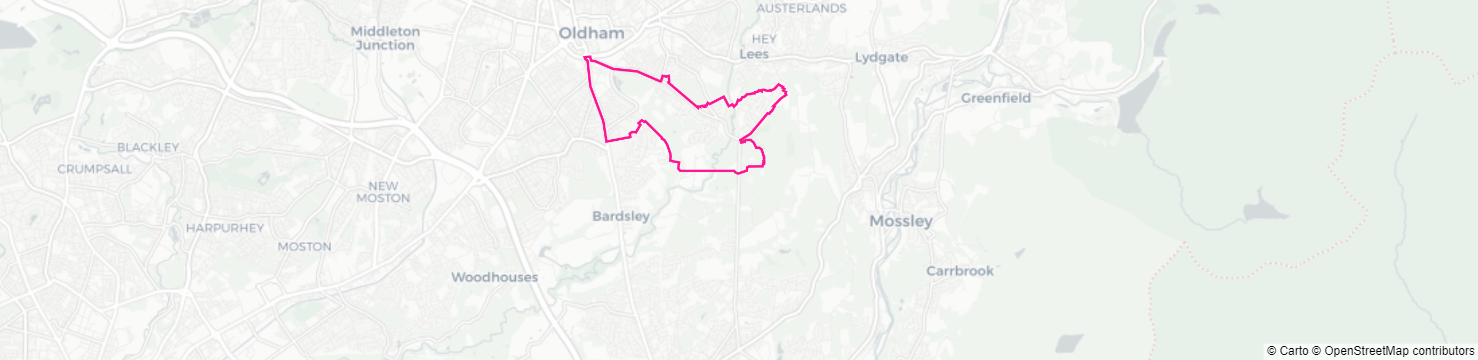

In [48]:
import plotly_express as px

mapbox_fig = px.scatter_mapbox( 
        data_frame=[],
        lat=[51.82906],
        lon=[-3.45886],
        # color_continuous_scale=px.colors.sequential.dense,
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=22,
        center={"lat": 51.82906, "lon": -3.45886},
        zoom=10,
        mapbox_style="carto-positron",
    ) \
        .update_layout(
        mapbox={
            "style": "carto-positron",
            "layers": [
                {
                    "source": json.loads(area_cd_geo_json),
                    "below": "traces",
                    "type": "line",
                    "color": "deeppink",
                    "line": {"width": 2.5},
                }
            ],
        },
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
    
mapbox_fig.show()

In [20]:
GPD_ALL_AREA_DIM['poly'][:1]

area       area_lvl
W06000016  lad         POLYGON ((-3.45886 51.82906, -3.45835 51.82873...
Name: poly, dtype: geometry

In [ ]:
pdf_district_dim = spark.read.parquet(f"{DATA_PATH}/processed/district_dim").toPandas().set_index("district")
gpd_district_dim = gpd.GeoDataFrame(pdf_district_dim, geometry="district_poly_fc")

In [19]:
pdf = pd.read_parquet("/mnt/c/wsl_transfers/cens_staging/geo_parquets/_wards/").set_index('WD22CD')


In [26]:
# gpd_ward = gpd.GeoDataFrame(pdf, geometry="poly_4326")

In [23]:
gpd.read_parquet("/mnt/c/wsl_transfers/cens_staging/geo_parquets/_wards/")

ValueError: Missing geo metadata in Parquet/Feather file.
            Use pandas.read_parquet/read_feather() instead.

In [29]:
GPD_ALL_AREA_DIM = gpd.read_parquet(f"/home/basal/live_datasets/processed/all_area_dim")

area       area_lvl
W06000016  lad         POLYGON ((-3.45886 51.82906, -3.45835 51.82873...
Name: poly, dtype: geometry